In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
# The current version of seaborn generates a bunch of warnings that we'll ignore
import warnings 
warnings.filterwarnings("ignore")

In [2]:
#Importing raw data
driver_id = pd.read_excel('dataset.xlsx', sheetname='Driver Id')
rider_id = pd.read_excel('dataset.xlsx', sheetname='rider Id')
rider_timestamp = pd.read_excel('dataset.xlsx', sheetname='ride timestamp')

In [3]:
rider_timestamp = rider_timestamp.pivot(index='ride_id', columns='event', values='timestamp')

In [4]:
# Merging data
df = pd.merge(rider_id, rider_timestamp, on='ride_id', how='inner')
df1 = pd.merge(df, driver_id, on='driver_id', how='inner')

In [5]:
dicts = {}
driver_list = df1['driver_id'].unique().tolist()
for driver in driver_list:
        dicts[driver] = df1[df1['driver_id'] == driver]['requested_at'].max()

df2 = pd.DataFrame.from_dict(dicts, orient='index')
df2 = df2.reset_index()
df2 = df2.rename(columns={'index': 'driver_id', 0: 'last_ride'})

In [6]:
df3 = pd.merge(df1, df2, on='driver_id', how='inner')

#Calculating the ride cost
Base_Fare = 2
Cost_per_Mile = 1.15
Cost_per_Minute = 0.22
Service_Fee = 1.75

df3['ride_distance'] = df3['ride_distance']/1609.344
df3['ride_duration'] = df3['ride_duration']/60
#Calculating ride cost
df3['ride_cost'] = (Base_Fare + (df3['ride_distance'])*Cost_per_Mile + \
                    (df3['ride_duration'])*Cost_per_Minute + Service_Fee)

#Assumption: Prime time is taken to be a multiplier to the calculated ride cost
#Prime time value of 0 = 1x Multiplier
#Prime time value of 25 = 1.25x Multiplier
#Prime time value of 50 = 1.50x Multiplier
#Prime time value of 100 = 2x Multiplier
df3['ride_cost'] = df3[['ride_cost','ride_prime_time']].apply(lambda x: \
                                                              x['ride_cost'] \
                                                              if x['ride_prime_time']==0 \
                                                              else (1 + x['ride_prime_time']/100)*x['ride_cost'], axis=1)
#Adjusting cost per min and max ride charges
df3['ride_cost'] = np.where(df3['ride_cost']<5,5,df3['ride_cost'])
df3['ride_cost'] = np.where(df3['ride_cost']>400,400,df3['ride_cost'])
df3['request_date'] = df3.requested_at.apply(lambda x: x.date())
df3['rqst_to_accpt_time'] = df3.accepted_at - df3.requested_at
df3['accpt_to_arrive_time'] = df3.arrived_at - df3.accepted_at
df3['arrive_to_pkup_time'] = df3.picked_up_at - df3.arrived_at
#Checking if the ride is in prime time and assigning value as such
df3['prime_instance'] = np.where(df3['ride_prime_time'] == 0,0,1)

In [7]:
#Calculating the following variables for use in further analysis and creating a table
#Cum_ride_count = Cumulative(Total) number of rides taken by the driver
#Ind_ride_count = Instance of ride per driver
#Ind_ride_distance = Ride distance
#ind_prime_count = Instance of prime time ride
#prior_active_date = Last time the driver took a ride
#data_last_date = Last time the driver accepted and took a ride
#inactive_since_last_active_date = Inactive days for the driver
#inactive_days = No. of days driver did not drive
#avg_cum_cost_per_distance = Average cumulative cost per distance travelled
#avg_cost_per_ride = Average cost per ride

df4 = pd.DataFrame({'cum_ride_count':df3[['driver_id','request_date']].groupby(['driver_id','request_date']).\
                    size().groupby(level=[0]).cumsum()})


#Ind_ride_count = ride count for the driver
df4['ind_ride_count'] = df3[['driver_id','request_date']].groupby(['driver_id','request_date']).\
size()
#Importing ride cost, ride distance , and assigns value if the ride is taken in prime time.
df4[['ind_ride_cost','ind_ride_distance','ind_prime_count']] = df3[['driver_id','ride_cost','ride_distance','request_date','prime_instance']].\
groupby(['driver_id','request_date']).\
agg({'ride_cost':'sum','ride_distance':'sum','prime_instance':'sum'})

#Calculating averages of ride cost, ride distance and prime rides count per driver
df4[['avg_ride_cost','avg_ride_distance','avg_prime_count']] = df3[['driver_id','ride_cost','ride_distance','request_date','prime_instance']].\
groupby(['driver_id','request_date']).\
agg({'ride_cost':'mean','ride_distance':'mean','prime_instance':'mean'})

#Calculating cumulative ride cost
df4[['cum_ride_cost','cum_ride_distance','cum_prime_count']] = df3[['driver_id','ride_cost','ride_distance',\
                                                           'request_date','prime_instance']].\
groupby(['driver_id','request_date']).\
agg({'ride_cost':'sum','ride_distance':'sum','prime_instance':'sum'}).groupby(level=[0]).cumsum()

df4 = df4.reset_index()

df4['prior_active_date'] = df4['request_date'].shift(1)
df4['prior_driver_id'] = df4['driver_id'].shift(1)

df4 = pd.merge(df4, driver_id, on='driver_id', how='inner')

df4['prior_active_date'] = pd.to_datetime(df4['prior_active_date'])
df4['request_date'] = pd.to_datetime(df4['request_date'])
df4['data_last_date'] = max(df4['request_date'])

df4['driver_last_date'] = df4.groupby(['driver_id'])['request_date'].transform('max')

df4['new_prior_active_date'] = np.where(df4.prior_driver_id == df4.driver_id,\
                                        df4['prior_active_date'],df4['driver_onboard_date'])
df4['inactive_since_last_active_date'] = (df4['data_last_date'] - df4['driver_last_date']).apply(lambda x: x.days)

df4['inactive_days'] = df4['request_date'] - df4['new_prior_active_date'] - datetime.timedelta(1)
df4.loc[df4['inactive_days'] < datetime.timedelta(0),'inactive_days'] = datetime.timedelta(0)
df4['inactive_days'] = df4['inactive_days'].apply(lambda x: x.days)
df4['avg_cum_cost_per_dist'] = df4['cum_ride_cost']/df4['cum_ride_distance']
df4['avg_cum_cost_per_ride'] = df4['cum_ride_cost']/df4['cum_ride_count']

df4.fillna(0)

df4['cum_inactive_days'] = df4.groupby(['driver_id'])['inactive_days'].cumsum().tolist()
df4.drop(['prior_active_date', 'prior_driver_id'], axis=1, inplace = True)

In [8]:
#checking all the columns made in the previous block of code
df4.columns

Index(['driver_id', 'request_date', 'cum_ride_count', 'ind_ride_count',
       'ind_ride_cost', 'ind_ride_distance', 'ind_prime_count',
       'avg_ride_cost', 'avg_ride_distance', 'avg_prime_count',
       'cum_ride_cost', 'cum_ride_distance', 'cum_prime_count',
       'driver_onboard_date', 'data_last_date', 'driver_last_date',
       'new_prior_active_date', 'inactive_since_last_active_date',
       'inactive_days', 'avg_cum_cost_per_dist', 'avg_cum_cost_per_ride',
       'cum_inactive_days'],
      dtype='object')

In [9]:
df4[['driver_id','ind_ride_cost','ind_ride_count','cum_ride_count','cum_ride_cost']].head()

,driver_id,ind_ride_cost,ind_ride_count,cum_ride_count,cum_ride_cost
0,002be0ffdc997bd5c50703158b7c2491,53.691565,6,6,53.691565
1,002be0ffdc997bd5c50703158b7c2491,79.821687,8,14,133.513252
2,002be0ffdc997bd5c50703158b7c2491,73.985948,7,21,207.499200
3,002be0ffdc997bd5c50703158b7c2491,45.981768,5,26,253.480968
4,002be0ffdc997bd5c50703158b7c2491,74.715055,7,33,328.196023


In [10]:
#Cumulative ride cost for the driver (Lifetime value of driver)
df4[['cum_ride_cost','driver_id']].groupby(['driver_id']).max()

,cum_ride_cost
driver_id,
002be0ffdc997bd5c50703158b7c2491,3654.984968
007f0389f9c7b03ef97098422f902e62,332.432198
011e5c5dfc5c2c92501b8b24d47509bc,494.240355
0152a2f305e71d26cc964f8d4411add9,2646.743733
01674381af7edd264113d4e6ed55ecda,5463.341520
0213f8b59219e32142711992ca4ec01f,2984.469654
021e5cd15ef0bb3ec20a12af99e142b3,707.241542
0258e250ca195cc6258cbdc75aecd853,4340.860202
028b5a4dcd7f4924ebfabcf2e814c014,5267.087720


In [11]:
#Initializing more variables
#time_active_with_ABC = time active from the on boarding date to the last ride taken
#active_days = No. of active days on ABC platform
#inactive_percentage = (No. of inactive days/Time active with ABC)*100
#inactive_percentage_diff = (No. of inactive days/Active no. of days on ABC platform)*100

df4['time_active_with_ABC'] = df4['data_last_date'] - df4['driver_onboard_date']

df4['time_active_with_ABC'] = df4['time_active_with_ABC'].apply(lambda x: x.days)
df4['active_days'] = df4['request_date'] - df4['driver_onboard_date']
df4['active_days'] = df4['active_days'].apply(lambda x: x.days)
df4['inactive_percentage'] = (df4['cum_inactive_days']/df4['time_active_with_ABC'])*100
df4['inactive_percentage_diff'] = (df4['cum_inactive_days']/df4['active_days'])*100

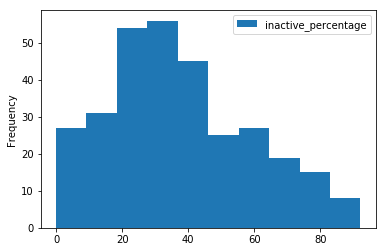

In [12]:
df4[['driver_id','inactive_percentage']].groupby(['driver_id']).max().reset_index().plot(kind='hist')

In [13]:
#Defining churn as the driver where inactive percentage is greater than 75%.
#Assuming that the person would be quitting shortly if he is inactive for long time.

df4['churn'] =  np.where(df4['inactive_percentage'] > 75,1,0)
df4.drop_duplicates(subset='driver_id',keep = 'last',inplace=True)

In [14]:
df4[df4['churn'] == 1].shape

(21, 27)

In [15]:
ABC_data = df4[['cum_ride_count', 'ind_ride_count',\
                 'ind_ride_cost', 'ind_ride_distance', 'ind_prime_count',\
                 'avg_ride_cost', 'avg_ride_distance', 'avg_prime_count',\
                 'cum_ride_cost', 'cum_ride_distance', 'cum_prime_count',
                'avg_cum_cost_per_dist', 'avg_cum_cost_per_ride',\
                 'inactive_percentage_diff','churn']]

In [16]:
ABC_data['churn'] = ABC_data['churn'].astype('category')
ABC_data.dtypes

cum_ride_count                 int64
ind_ride_count                 int64
ind_ride_cost                float64
ind_ride_distance            float64
ind_prime_count                int32
avg_ride_cost                float64
avg_ride_distance            float64
avg_prime_count              float64
cum_ride_cost                float64
cum_ride_distance            float64
cum_prime_count                int32
avg_cum_cost_per_dist        float64
avg_cum_cost_per_ride        float64
inactive_percentage_diff     float64
churn                       category
dtype: object

In [17]:
ABC_data.head()

,cum_ride_count,ind_ride_count,ind_ride_cost,ind_ride_distance,ind_prime_count,avg_ride_cost,avg_ride_distance,avg_prime_count,cum_ride_cost,cum_ride_distance,cum_prime_count,avg_cum_cost_per_dist,avg_cum_cost_per_ride,inactive_percentage_diff,churn
55,277,5,103.834813,30.673989,4,20.766963,6.134798,0.800000,3654.984968,1081.364208,110,3.379976,13.194892,36.046512,0
67,31,2,13.405615,2.329521,0,6.702808,1.164760,0.000000,332.432198,73.030378,12,4.551972,10.723619,87.058824,1
79,34,5,50.849780,14.159807,2,10.169956,2.831961,0.400000,494.240355,167.554606,16,2.949727,14.536481,83.823529,0
119,191,3,38.148241,13.521659,0,12.716080,4.507220,0.000000,2646.743733,914.185531,48,2.895193,13.857297,37.500000,0
159,375,9,141.677432,47.665384,6,15.741937,5.296154,0.666667,5463.341520,1940.942396,99,2.814788,14.568911,30.357143,0


In [18]:
# Split Dependent/Independent Variables
X = np.asarray(ABC_data.drop('churn', axis=1))
y = np.asarray(ABC_data['churn'])

In [19]:
#Implementing decision trees to find variables affecting driver churn 
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
score_list = ['accuracy', 'recall', 'precision', 'f1']
search_depths = [5, 10, 15]

for d in search_depths:
    dtc = DecisionTreeClassifier(criterion='gini', max_depth=d, min_samples_split=5, min_samples_leaf=5)
    mean_score = []
    std_score = []
    print("max_depth=", d)
    print("{:.<13s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
    for s in score_list:
        dtc_5 = cross_val_score(dtc, X, y, scoring=s, cv=5)
        mean = dtc_5.mean()
        std = dtc_5.std()
        mean_score.append(mean)
        std_score.append(std)
        print("{:.<13s}{:>7.4f}{:>10.4f}".format(s, mean, std))

max_depth= 5
Metric.......  Mean    Std. Dev.
accuracy..... 0.9479    0.0192
recall....... 0.5700    0.0980
precision.... 0.6900    0.2154
f1........... 0.6056    0.1144
max_depth= 10
Metric.......  Mean    Std. Dev.
accuracy..... 0.9511    0.0232
recall....... 0.5700    0.0980
precision.... 0.6800    0.2112
f1........... 0.6056    0.1144
max_depth= 15
Metric.......  Mean    Std. Dev.
accuracy..... 0.9511    0.0232
recall....... 0.5700    0.0980
precision.... 0.6900    0.2154
f1........... 0.6056    0.1144


In [20]:
#Fitting on best parameter
from sklearn.model_selection import train_test_split
x_train, x_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.3, random_state = 12345)
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=5, min_samples_leaf=5)
dt = dt.fit(x_train, y_train)

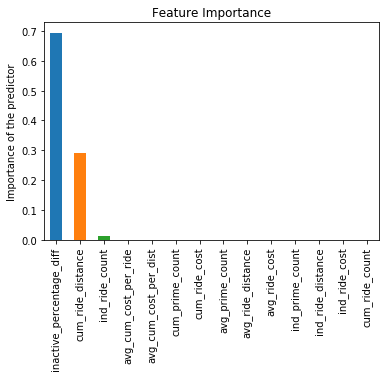

In [21]:
#Below is the feature importance diagram for driver churn
predictors = ['cum_ride_count', 'ind_ride_count',\
              'ind_ride_cost', 'ind_ride_distance', 'ind_prime_count',\
              'avg_ride_cost', 'avg_ride_distance', 'avg_prime_count',\
              'cum_ride_cost', 'cum_ride_distance', 'cum_prime_count',\
              'avg_cum_cost_per_dist', 'avg_cum_cost_per_ride',\
              'inactive_percentage_diff']
feature_imp = pd.Series(dt.feature_importances_,predictors).sort_values(ascending=False)
feature_imp.plot(kind='bar',title='Feature Importance')
plt.ylabel('Importance of the predictor')
plt.show()

In [22]:
# Split Dependent/Independent Variables for cum_ride_cost (Life time value of the driver to ABC)
X_r = np.asarray(ABC_data.drop(['churn','cum_ride_cost'], axis=1))
y_r = np.asarray(ABC_data['cum_ride_cost'])

In [23]:
#Implementing decision trees for cum_ride_cost (Life time value of the driver)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
score_list = ['neg_mean_squared_error', 'neg_mean_absolute_error']
score_names = ['MSE', 'MAE']
search_depths = [5, 6, 7, 8, 10]

for d in search_depths:
    dtc = DecisionTreeRegressor(criterion='mse', max_depth=d, min_samples_split=5, min_samples_leaf=5)
    mean_score = []
    std_score = []
    print("max_depth=", d)
    print("{:.<13s}{:>6s}{:>13s}".format("Metric", "Mean", "Std. Dev."))
    for counter, value in enumerate(score_list):
        dtc_10 = cross_val_score(dtc, X_r, y_r, scoring=value, cv=10)
        mean = dtc_10.mean()
        std = dtc_10.std()
        mean_score.append(mean)
        std_score.append(std)
        print("{:.<13s}{:>7.4f}{:>10.4f}".format(score_names[counter], mean, std))

max_depth= 5
Metric.......  Mean    Std. Dev.
MSE..........-203059.5916100095.5775
MAE..........-255.7578   44.0543
max_depth= 6
Metric.......  Mean    Std. Dev.
MSE..........-191382.4048102356.7728
MAE..........-245.6881   39.4958
max_depth= 7
Metric.......  Mean    Std. Dev.
MSE..........-190614.1618108951.7122
MAE..........-238.9916   45.9169
max_depth= 8
Metric.......  Mean    Std. Dev.
MSE..........-192236.6645105584.9366
MAE..........-239.5357   47.8284
max_depth= 10
Metric.......  Mean    Std. Dev.
MSE..........-192226.2009105590.3029
MAE..........-239.5394   47.9035


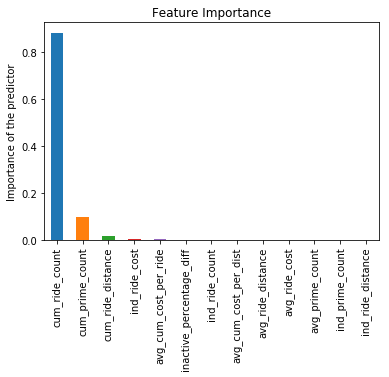

In [24]:
#Below is the feature importance for the cum_ride_cost (Life time value of driver to X)
dt = DecisionTreeRegressor(max_depth=10, min_samples_split=5, min_samples_leaf=5)
dt = dt.fit(X_r, y_r)

predictors = ['cum_ride_count', 'ind_ride_count',\
              'ind_ride_cost', 'ind_ride_distance', 'ind_prime_count',\
              'avg_ride_cost', 'avg_ride_distance', 'avg_prime_count',\
              'cum_ride_distance', 'cum_prime_count',\
              'avg_cum_cost_per_dist', 'avg_cum_cost_per_ride',\
              'inactive_percentage_diff']

feature_imp = pd.Series(dt.feature_importances_,predictors).sort_values(ascending=False)
feature_imp.plot(kind='bar',title='Feature Importance')
plt.ylabel('Importance of the predictor')
plt.show()

In [25]:
#Assumption: The last day they took accepted a ride is taken as their last day.
#Life time of a driver 
df4['Stay'] = df4['driver_last_date'] - df4['driver_onboard_date']
df4['Stay'].describe()

count                        307
mean     55 days 21:29:54.136807
std      21 days 03:54:00.895141
min              3 days 00:00:00
25%             41 days 12:00:00
50%             59 days 00:00:00
75%             73 days 12:00:00
max             89 days 00:00:00
Name: Stay, dtype: object

In [26]:
#Lifetime value of a driver to ABC.
df4[['cum_ride_cost']].describe()

,cum_ride_cost
count,307.000000
mean,3075.638251
std,2554.126873
min,115.049188
25%,602.733379
50%,2984.704487
75%,4708.156216
max,12619.119144
